# Predicting Stock Prices

## Bharat Intern Task 
## -Sakshi Jain
## Task: Stock Price Prediction


Link to Datasets: https://www.kaggle.com/code/sakshijain27/stock-price-prediction-using-lstm/input

# Import libraries

- The script imports the required libraries for the task, including NumPy, Pandas, Matplotlib, pandas_datareader, datetime, and TensorFlow.
- It sets up the necessary tools for data retrieval, such as the web data reader for fetching stock market data.
- The data preprocessing steps involve scaling the data using MinMaxScaler from scikit-learn, which transforms the data into a specific range (usually between 0 and 1).
- The LSTM neural network is implemented using Keras from TensorFlow, which is a popular deep learning library.
- The neural network architecture consists of a Sequential model, where layers can be added in a linear manner.
- The LSTM layer is used for its ability to capture long-term dependencies in sequential data like stock prices.
- Dropout layers are included to prevent overfitting, as they randomly deactivate some neurons during training.
- The model is configured with Dense layers for the output and hidden layers.
- ModelCheckpoint and EarlyStopping callbacks are used to save the best model during training and stop early if the validation loss stops improving, respectively.

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Preprocessing

The code loads a CSV file named "preprocessed_CAC40.csv" into a Pandas DataFrame.
The dataset likely contains information related to the CAC 40, which is a stock market index representing the 40 largest publicly traded companies in France.
The 'parse_dates' parameter is used to ensure that the 'Date' column is treated as datetime objects, allowing for time-series analysis.

In [2]:
# Load csv
df = pd.read_csv('../input/cac40-stocks-dataset/preprocessed_CAC40.csv', parse_dates=['Date'])

The function is named `load_data` and is designed to load stock market data for a specified company within a given date range.
- The function starts by creating a copy of the original DataFrame `df` (presumably containing data related to the CAC 40 stocks) to work with, ensuring that the original DataFrame remains unchanged.
- It filters the data to extract rows that match the specified `company` using the 'Name' column.
- The data is further filtered to include only rows that fall within the specified date range, using the 'Date' column.
- The 'Closing_Price' column is renamed as 'Close' for clarity.
- The resulting filtered data for the specified company and date range is returned as a new DataFrame.

In [3]:
def load_data(company,start,end):
    """"
    Load data for the specified company an data range.
    :param company:The company's stock symbol(str)
    :param start:The starting date for the data range(string or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return:  A dataframe containig the relevant  stock data (pandas.DataFrame)
    """
    dataframe=df.copy()
    dataframe=dataframe.loc[dataframe.Name== company, :]
    dataframe=dataframe.loc[(dataframe['Date']>start)&(dataframe['Date']<end),:]
    dataframe=dataframe.rename(columns={'Closing_Price':'Close'})
    return dataframe

In [4]:
COMPANY='Accor'
START_DATE=dt.datetime(2015,1,1)
END_DATE=dt.datetime(2020,1,1)

START_DATE_TEST=END_DATE

In [5]:
data=load_data(company=COMPANY,
              start=START_DATE,
              end=END_DATE)

The code involves data normalization using the MinMaxScaler.
- The MinMaxScaler is initialized with the feature range set between 0 and 1, which ensures that the scaled data will be within this range.
- The data to be normalized is extracted from the 'Close' column of the DataFrame 'data'.
- The 'Close' column is selected and reshaped into a 2D array with a single column using `values.reshape(-1,1)`. This is required by the MinMaxScaler, which expects a 2D array as input.
- The scaler is then applied to the data using `scaler.fit_transform()`.
- The `fit_transform()` method computes the minimum and maximum values in the 'Close' column and scales the data accordingly.
- The scaled data is stored in the variable `scaled_data`, which is now a NumPy array.
 This scaled data is ready to be used for training machine learning models, such as the LSTM model mentioned earlier.

In [6]:
#Normalize data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))

- The code sets the variable `prediction_days` to 60. This variable represents the number of days to be used for predicting future stock prices.
- Two empty lists, `x_train` and `y_train`, are initialized to store the training data input and output, respectively. These lists will be populated with data for training the LSTM model.
- The code iterates through the `scaled_data`, starting from the index equal to the `prediction_days`. This is done to create sequences of data that will be used for training the LSTM model.
- For each iteration, the previous `prediction_days` values are appended to `x_train`. This forms the input data for the LSTM model, where each input sequence contains historical stock prices.
- The current value (corresponding to the next day's stock price) is appended to `y_train`, which represents the corresponding output or the target value for the LSTM model.
- After the loop, `x_train` and `y_train` are converted into NumPy arrays using `np.array()` for further processing and compatibility with the LSTM model.
- The `x_train` array is then reshaped to a 3D array with the appropriate dimensions required for the LSTM model. The new shape will be `(number_of_samples, prediction_days, 1)`, where `number_of_samples` is the total number of training samples.

This block of code prepares the data in the format required for training an LSTM model for stock price prediction. The `x_train` will contain sequences of historical stock prices, while `y_train` will contain the corresponding target values (next day's stock prices).

In [7]:
# Set the number of days for prediction
prediction_days=60

#Intialize empty lists for training data input and output
x_train=[]
y_train=[]

#Iterate tthrough the scaled data, starting ffrom the prediction days index
for x in range(prediction_days,len(scaled_data)):
    #Append the previous prediction days values to x_train
    x_train.append(scaled_data[x-prediction_days:x,0])
    #Append the current value to y_train
    y_train.append(scaled_data[x,0])
    
#Convert the x_train and y_train lists to numpy arrays 
x_train, y_train=np.array(x_train),np.array(y_train)

#reshape x_train to a D array with the appropriate dimensions for the LSTM Model
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

# LSTM MODEL


 The LSTM model is designed for stock price prediction.
- It consists of three LSTM layers, each with 50 units, enabling the model to capture long-term dependencies in the data.
- Dropout layers with a rate of 0.2 are included after each LSTM layer to prevent overfitting and enhance generalization.
- The output layer is a dense layer with one unit, which produces the predicted stock price as the output.
- The model is configured to take input sequences of historical stock prices, with the number of time steps determined by the `x_train.shape[1]`.
- This LSTM model is suitable for forecasting future stock prices based on past trends and patterns in the stock market data.

In [8]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

# Training

 The LSTM model is created using the `LSTM_model()` function.
- The `model.summary()` function is called to display a summary of the model architecture, showing the layers, parameters, and output shapes.
- The model is compiled using the 'adam' optimizer, which is a popular optimizer for training neural networks based on adaptive learning rates.
- The loss function chosen for this model is 'mean_squared_error', which measures the mean squared difference between the predicted and actual stock prices during training.
- With the model compiled, it is now ready for training with historical stock price data to learn patterns and make predictions.

In [9]:
model=LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

 Callbacks are defined to enhance the training process of the LSTM model.
- The `ModelCheckpoint` callback is used to save the weights of the model during training.
- Weights will be saved to the file named 'weights_best.hdf5'.
- The `verbose` parameter is set to 2, providing detailed updates during the training process.
- Only the weights for the best model (lowest validation loss) will be saved due to `save_best_only = True`.
- The model is then trained using the `model.fit()` function.
- Historical stock price data, `x_train`, and corresponding target values, `y_train`, are used for training.
- The training process will run for 25 epochs, iterating through the entire dataset 25 times.
- A batch size of 32 is used, indicating that the model will update its weights after processing 32 samples.
- The `ModelCheckpoint` callback is passed to the `callbacks` parameter to enable weight saving during training.
- The model will be trained and improved over the epochs, and the best-performing model's weights will be saved for future use.

In [10]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
38/38 [==============================] - 9s 80ms/step - loss: 0.0385
Epoch 2/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0108
Epoch 3/25
38/38 [==============================] - 3s 80ms/step - loss: 0.0103
Epoch 4/25
38/38 [==============================] - 3s 78ms/step - loss: 0.0095
Epoch 5/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0084
Epoch 6/25
38/38 [==============================] - 3s 88ms/step - loss: 0.0086
Epoch 7/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0082
Epoch 8/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0072
Epoch 9/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0073
Epoch 10/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0072
Epoch 11/25
38/38 [==============================] - 3s 78ms/step - loss: 0.0068
Epoch 12/25
38/38 [==============================] - 3s 77ms/step - loss: 0.0069
Epoch 13/25
38/38 [==================

# Inference

In [11]:
# Load the test data for the specified company and date range
test_data=load_data(
company=COMPANY,
start=START_DATE_TEST,
end=dt.datetime.now()
)
# Extract the actual closing price from the test data
actual_price=test_data['Close'].values

#Concatenate the training and test data along the 'Close' column
total_dataset=pd.concat((data['Close'],test_data['Close']),axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values

#Reshape the model inputs to a 2D array with a single column
model_inputs=model_inputs.reshape(-1,1)

# Apply the same scaling used for trainig data to model inputs
model_inputs=scaler.transform(model_inputs)


In [12]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 [==============================] - 1s 21ms/step


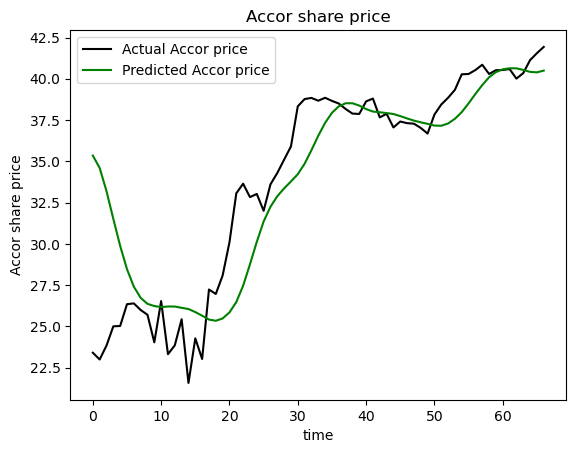

In [13]:
# Plot the actual prices using a black line
plt.plot(actual_price, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

This block of code demonstrates the steps involved in predicting future stock prices using the LSTM model. The LSTM model takes the most recent 'prediction_days' days of data as input and generates a forecast for the next day's stock price. The prediction result is then converted back to its original scale for meaningful interpretation.

In [14]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 1s 1s/step
Prediction: 40.734962463378906
